# SBB

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import networkx as nx

## Import Data

In [2]:
df = pd.read_csv('data/zugzahlen.csv')

In [3]:
df.head(5)

,PID,ISB,Strecke_Nummer,Strecke_Bezeichnung,Strecke_Art,BP_Von_Abschnitt,BP_Von_Abschnitt_Bezeichnung,BP_Bis_Abschnitt,BP_Bis_Abschnitt_Bezeichnung,Anzahl_Zuege,BPUIC,KOORDZ,KOORDY,KOORDX,Name Haltestelle,TU Nummer,Bedienpunkt Cargo,land,geopos_von,geopos_bis
0,SBB_GESE_CHY,SBB,1,Genève Aéroport - Lausanne,STRECKE,GESE,Genève-Sécheron,CHY,Chambésy,126307,8516283,390.4,500153.08,119825.45,Genève-Sécheron,11,None,Switzerland,"6.14454714955, 46.2224480511","6.14732717469, 46.2423883571"
1,SBB_MIES_TAN,SBB,1,Genève Aéroport - Lausanne,STRECKE,MIES,Mies,TAN,Tannay,126101,8501014,394.7,502222.94,128400.90,Mies,11,None,Switzerland,"6.16956925257, 46.2998837999","6.18111951391, 46.3076442488"
2,SBB_MOR_STJ,SBB,1,Genève Aéroport - Lausanne,STRECKE,MOR,Morges,STJ,Morges-St-Jean,121566,8501037,381.2,527498.18,151525.28,Morges,11,*,Switzerland,"6.49396657295, 46.5110943408","6.5080466068, 46.5181943179"
3,SBB_TUI_GDBE,SBB,1,Genève Aéroport - Lausanne,STRECKE,TUI,Les Tuileries,GDBE,Genthod-Bellevue,126311,8501011,389.2,500417.99,122879.65,Les Tuileries,11,None,Switzerland,"6.14732757249, 46.2499580317","6.15395779335, 46.2567477219"
4,SBB_RUS_SY,SBB,3,La Plaine Frontière - Genève,STRECKE,RUS,Russin,SY,Satigny,40988,8501002,377.9,490285.68,116142.90,Russin,11,None,Switzerland,"6.01754977864, 46.1877882306","6.03749960767, 46.2142381831"


In [4]:
df['lon_von'] = df.geopos_von.str.split('\,').str[0]
df['lon_von'] = df['lon_von'].map(float)

In [5]:
df['lat_von'] = df.geopos_von.str.split('\,').str[1]
df['lat_von'] = df['lat_von'].map(float)

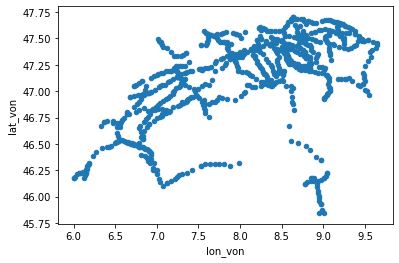

In [6]:
df.plot.scatter(x='lon_von', y ='lat_von');

In [7]:
df['lon_bis'] = df.geopos_bis.str.split('\,').str[0]
df['lon_bis'] = df['lon_bis'].map(float)

In [8]:
df['lat_bis'] = df.geopos_bis.str.split('\,').str[1]
df['lat_bis'] = df['lat_bis'].map(float)

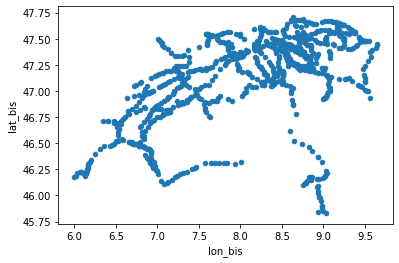

In [9]:
df.plot.scatter(x='lon_bis', y ='lat_bis');

In [10]:
pos_von = {}
for i in range(0, len(df)):
    pos_von[df.BP_Von_Abschnitt[i]] = (df.lon_von[i], df.lat_von[i])

In [11]:
pos_bis = {}
for i in range(0, len(df)):
    pos_bis[df.BP_Bis_Abschnitt[i]] = (df.lon_bis[i], df.lat_bis[i])

In [12]:
# Magic merge of dictionaries
pos = {**pos_bis, **pos_von}

In [13]:
len(pos)

1002

## Building the Network

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
D = nx.from_pandas_edgelist(df, source = 'BP_Von_Abschnitt', target = 'BP_Bis_Abschnitt', edge_attr = 'Anzahl_Zuege', create_using = nx.DiGraph())

In [16]:
len(D.nodes())

1002

In [17]:
len(D.edges())

848

In [18]:
#D.edges(data=True)

In [19]:
G = nx.Graph(D)

In [20]:
len(G.nodes())

1002

In [21]:
len(G.edges())

848

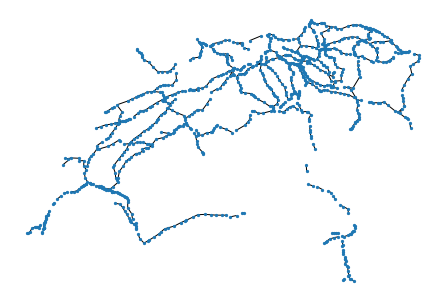

In [22]:
nx.draw(G, pos=pos, with_labels=False, node_size=5)

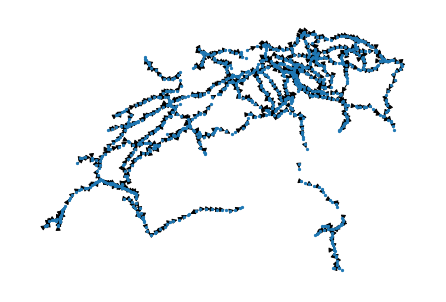

In [23]:
nx.draw(D, pos=pos, with_labels=False, node_size=5)